::: {.callout-note collapse="false"}
## Learning Outcomes
* Understand the difference between regression and classification
* Derive the logistic regression model for classifying data
* Quantify the error of our logistic regression model with cross-entropy loss
:::


Up until this point in the class , we've focused on **regression** tasks - that is, predicting a *numerical* quantity from a given dataset. We discussed optimization, feature engineering, and regularization all in the context of performing regression to predict some quantity. 

Now that we have this deep understanding of the modeling process, let's expand our knowledge of possible modeling tasks. 


## Classification

In the next two lectures, we'll tackle the task of **classification**. A classification problem aims to classify data into  *categories*. Unlike in regression, where we predicted a numeric output, classification involves predicting some **categorical variable**, or **response**, $y$. Examples of classification tasks include:

* Predicting which team won from its turnover percentage 
* Predicting the day of the week of a meal from the total restaurant bill 
* Predicting the model of car from its horsepower

There are a couple of different types of classification:

* Binary classification: classify data into two classes, and responses $y$ are either 0 or 1
* Multiclass classification: classify data into multiple classes (e.g., image labeling, next word in a sentence, etc.)
* Structured prediction tasks: conduct mutliple related classification predictions (e.g., translation, voice recognition, etc.)

In Data 100, we will mostly deal with **binary classification**, where we are attempting to classify data into one of two classes. 

To build a classification model, we need to modify our modeling workflow slightly. Recall that in regression we:

1. Created a design matrix of numeric features
2. Defined our model as a linear combination of these numeric features
3. Used the model to output numeric predictions

In classification, however, we no longer want to output numeric predictions; instead, we want to predict the class to which a datapoint belongs. This means that we need to update our workflow. To build a classification model, we will:

1. Create a design matrix of numeric features.
2. Define our model as a linear combination of these numeric features, transformed by a non-linear **sigmoid function**. This outputs a numeric quantity.
3. Apply a **decision rule** to interpret the outputted quantity and decide a classification.
4. Output a predicted class.

There are two key differences: as we'll soon see, we need to incorporate a non-linear transformation to capture non-linear relationships hidden in our data. We do so by applying the sigmoid function to a linear combination of the features. Secondly, we must apply a decision rule to convert the numeric quantities computed by our model into an actual class prediction. This can be as simple as saying that any datapoint with a feature greater than some number $x$ belongs to Class 1.

<center><img src="images/reg.png" alt='reg' width='750'></center>

<center><img src="images/class.png" alt='class' width='750'></center>

This was a very high-level overview. Let's walk through the process in detail to clarify what we mean.

## Deriving the Logistic Regression Model

Throughout this lecture, we will work with the `games` dataset, which contains information about games played in the NBA basketball league. Our goal will be to use a basketball team's `"GOAL_DIFF"` to predict whether or not a given team won their game (`"WON"`). If a team wins their game, we'll say they belong to Class 1. If they lose, they belong to Class 0.

For those who are curious, `"GOAL_DIFF"` represents the difference in successful field goal percentages between the two competing teams. 

In [3]:
#| code-fold: true
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
np.seterr(divide='ignore')

games = pd.read_csv("data/games").dropna()
games.head()

,GAME_ID,TEAM_NAME,MATCHUP,WON,GOAL_DIFF,AST
0,21701216,Dallas Mavericks,DAL vs. PHX,0,-0.251,20
1,21700846,Phoenix Suns,PHX @ GSW,0,-0.237,13
2,21700071,San Antonio Spurs,SAS @ ORL,0,-0.234,19
3,21700221,New York Knicks,NYK @ TOR,0,-0.234,17
4,21700306,Miami Heat,MIA @ NYK,0,-0.222,21


Let's visualize the relationship between `"GOAL_DIFF"` and `"WON"` using the Seaborn function `sns.stripplot`. A strip plot automatically introduces a small amount of random noise to jitter the data. Recall that all values in the `"WON"` column are either 1 (won) or 0 (lost) – if we were to directly plot them without jittering, we would see severe overplotting.

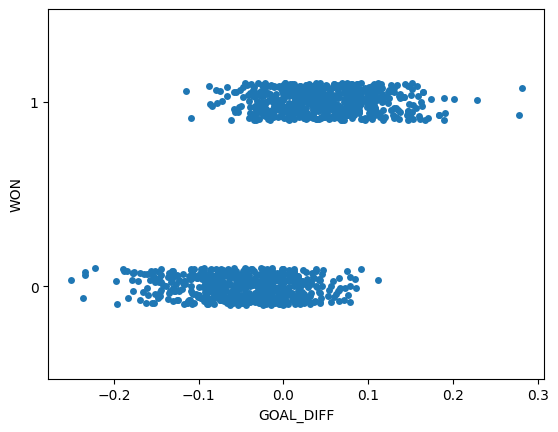

In [4]:
#| code-fold: true
import seaborn as sns
import matplotlib.pyplot as plt

sns.stripplot(data=games, x="GOAL_DIFF", y="WON", orient="h")
# By default, sns.stripplot plots 0, then 1. We invert the y axis to reverse this behavior
plt.gca().invert_yaxis();

This dataset is unlike anything we've seen before – our target variable contains only two unique values! Remember that each y value is either 0 or 1; the plot above jitters the y data slightly for ease of reading.

The regression models we have worked with always assumed that we were attempting to predict a continuous target. If we apply a linear regression model to this dataset, something strange happens.

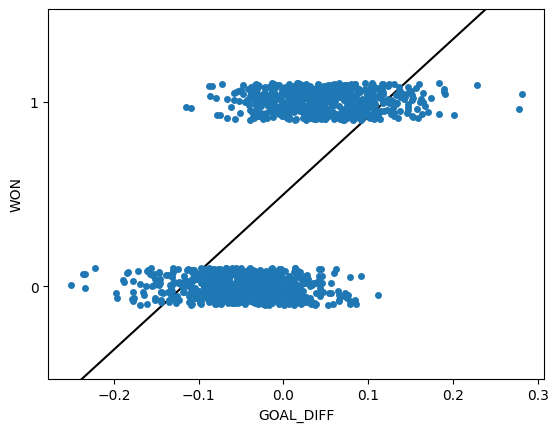

In [5]:
#| code-fold: true
import sklearn.linear_model as lm

X, Y = games[["GOAL_DIFF"]], games["WON"]
regression_model = lm.LinearRegression()
regression_model.fit(X, Y)

plt.plot(X.squeeze(), regression_model.predict(X), "k")
sns.stripplot(data=games, x="GOAL_DIFF", y="WON", orient="h")
plt.gca().invert_yaxis();

The linear regression fit follows the data as closely as it can. However, there are a few key flaws with this approach:

* The predicted output, $\hat{y}$, can be outside the range of possible classes (there are predictions above 1 and below 0)
* This means that the output can't always be interpreted (what does it mean to predict a class of -2.3?)

Our usual linear regression framework won't work here. Instead, we'll need to get more creative.

Back in [Data 8](https://inferentialthinking.com/chapters/08/1/Applying_a_Function_to_a_Column.html#example-prediction), you gradually built up to the concept of linear regression by using the **graph of averages**. Before you knew the mathematical underpinnings of the regression line, you took a more intuitive approach: you bucketed the $x$ data into bins of common values, then computed the average $y$ for all datapoints in the same bin. The result gave you the insight needed to derive the regression fit.

Let's take the same approach as we grapple with our new classification task. In the cell below, we 1) bucket the `"GOAL_DIFF"` data into bins of similar values and 2) compute the average `"WON"` value of all datapoints in a bin.

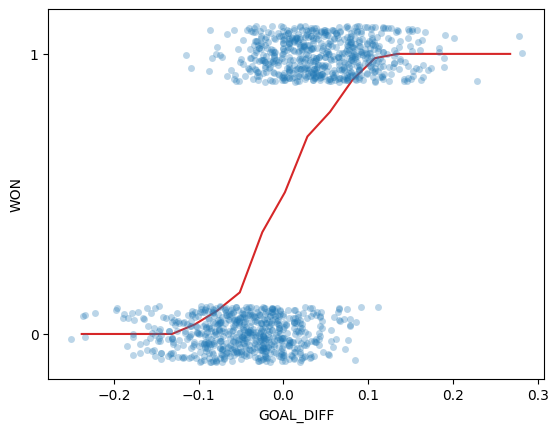

In [6]:
bins = pd.cut(games["GOAL_DIFF"], 20)
games["bin"] = [(b.left + b.right) / 2 for b in bins]
win_rates_by_bin = games.groupby("bin")["WON"].mean()

# alpha makes the points transparent so we can see the line more clearly
sns.stripplot(data=games, x="GOAL_DIFF", y="WON", orient="h", alpha=0.3)
plt.plot(win_rates_by_bin.index, win_rates_by_bin, c="tab:red")
plt.gca().invert_yaxis();

Interesting: our result is certainly not like the straight line produced by finding the graph of averages for a linear relationship. We can make two observations:

* All predictions on our line are between 0 and 1
* The predictions are **non-linear**, following a rough "S" shape

Let's think more about what we've just done.

To find the average $y$ value for each bin, we computed:

$$\frac{1 \text{(\# Y = 1 in bin)} + 0 \text{(\# Y = 0 in bin)}}{\text{\# datapoints in bin}} = \frac{\text{\# Y = 1 in bin}}{\text{\# datapoints in bin}} = P(\text{Y = 1} | \text{bin})$$

This is simply the probability of a datapoint in that bin belonging to Class 1! This aligns with our observation from earlier: all of our predictions lie between 0 and 1, just as we would expect for a probability.

Our graph of averages was really modeling the probability, $p$, that a datapoint belongs to Class 1, or essentially that $\text{Y = 1}$ for a particular value of $\text{x}$.

$$ p = P(Y = 1 | \text{ x} )$$

In logistic regression, we have a new modeling goal. We want to model the **probability that a particular datapoint belongs to Class 1**. To do so, we'll need to create a model that can approximate the S-shaped curve we plotted above.

Fortunately for us, we're already well-versed with a technique to model non-linear relationships – applying non-linear transformations to linearize the relationship. Recall the steps we've applied previously:

* Transform the variables until we linearize their relationship
* Fit a linear model to the transformed variables
* "Undo" our transformations to identify the underlying relationship between the original variables

In past examples, we used the bulge diagram to help us decide what transformations may be useful. The S-shaped curve we saw above, however, looks nothing like any relationship we've seen in the past. We'll need to think carefully about what transformations will linearize this curve.

Let's consider our eventual goal: determining if we should predict a Class of 0 or 1 for each datapoint. Rephrased, we want to decide if it seems more "likely" that the datapoint belongs to Class 0 or to Class 1. One way of deciding this is to see which class has the higher predicted probability for a given datapoint. The **odds** is defined as the probability of a datapoint belonging to Class 1 divided by the probability of it belonging to Class 0. 

$$\text{odds} = \frac{P(Y=1|x)}{P(Y=0|x)} = \frac{p}{1-p}$$

If we plot the odds for each input `"GOAL_DIFF"` ($x$), we see something that looks more promising.

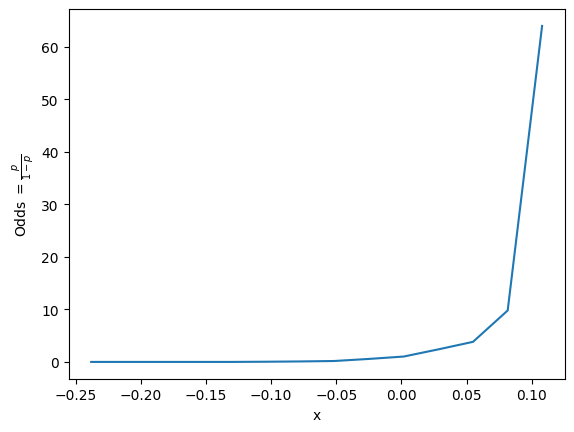

In [7]:
p = win_rates_by_bin
odds = p/(1-p) 

plt.plot(odds.index, odds)
plt.xlabel("x")
plt.ylabel(r"Odds $= \frac{p}{1-p}$");

It turns out that the relationship between our input `"GOAL_DIFF"` and the odds is roughly exponential! Let's linearize the exponential by taking the logarithm. As a reminder, you should assume that any logarithm in Data 100 is the base $e$ natural logarithm unless told otherwise.

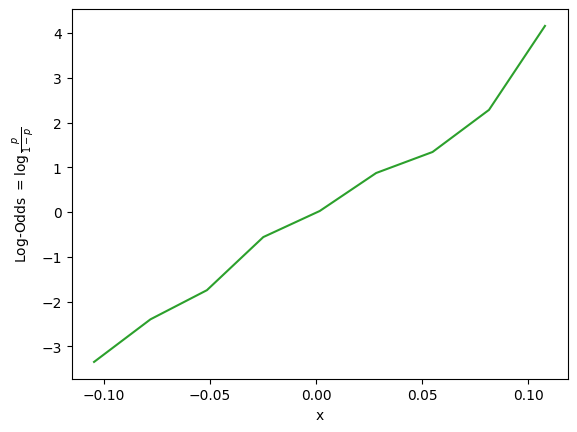

In [8]:
import numpy as np
log_odds = np.log(odds)
plt.plot(odds.index, log_odds, c="tab:green")
plt.xlabel("x")
plt.ylabel(r"Log-Odds $= \log{\frac{p}{1-p}}$");

We see something promising – the relationship between the log-odds and our input feature is approximately linear. This means that we can use a linear model to describe the relationship between the log-odds and $x$. In other words:

\begin{align}
\log{(\frac{p}{1-p})} &= \theta_0 + \theta_1 x_i\\
&= x^{\top} \theta
\end{align}

Here, we use $x^{\top}$ to represent an observation in our dataset, stored as a row vector. You can imagine it as a single row in our design matrix. $x^{\top} \theta$ indicates a linear combination of the features for this observation (just as we used in multiple linear regression). 

We're in good shape! We have now derived the following relationship:

$$\log{(\frac{p}{1-p})} = x^{\top} \theta$$

Remember that our goal is to predict the probability of a datapoint belonging to Class 1, $p$. Let's rearrange this relationship to uncover the original relationship between $p$ and our input data, $x^{\top}$.

\begin{align}
\log{(\frac{p}{1-p})} &= x^T \theta\\
\frac{p}{1-p} &= e^{x^T \theta}\\
p &= (1-p)e^{x^T \theta}\\
p &= e^{x^T \theta}- p e^{x^T \theta}\\
p(1 + e^{x^T \theta}) &= e^{x^T \theta} \\
p &= \frac{e^{x^T \theta}}{1+e^{x^T \theta}}\\
p &= \frac{1}{1+e^{-x^T \theta}}\\
\end{align}

Phew, that was a lot of algebra. What we've uncovered is the **logistic regression model** to predict the probability of a datapoint $x^{\top}$ belonging to Class 1. If we plot this relationship for our data, we see the S-shaped curve from earlier!

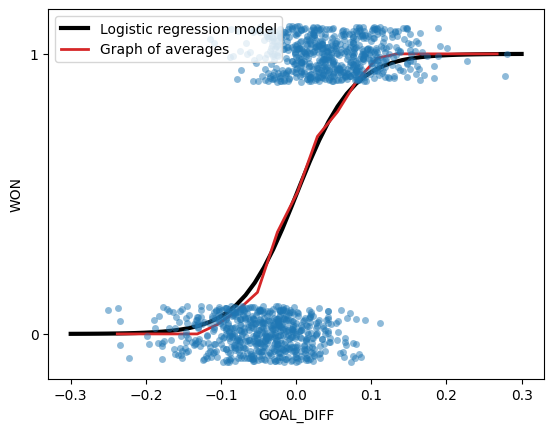

In [9]:
#| code-fold: true
# We'll discuss the `LogisticRegression` class next time
xs = np.linspace(-0.3, 0.3)

logistic_model = lm.LogisticRegression(C=20)
logistic_model.fit(X, Y)
predicted_prob = logistic_model.predict_proba(xs[:, np.newaxis])[:, 1]

sns.stripplot(data=games, x="GOAL_DIFF", y="WON", orient="h", alpha=0.5)
plt.plot(xs, predicted_prob, c="k", lw=3, label="Logistic regression model")
plt.plot(win_rates_by_bin.index, win_rates_by_bin, lw=2, c="tab:red", label="Graph of averages")
plt.legend(loc="upper left")
plt.gca().invert_yaxis();

To predict a probability using the logistic regression model, we:

1. Compute a linear combination of the features, $x^{\top}\theta$
2. Apply the sigmoid activation function, $\sigma(x^{\top} \theta)$.

Our predicted probabilities are of the form $P(Y=1|x) = p = \frac{1}{1+e^{-(\theta_0 + \theta_1 x_1 + \theta_2 x_2 + \ldots + \theta_p x_p)}}$

An important note: despite its name, logistic regression is used for *classification* tasks, not regression tasks. In Data 100, we always apply logistic regression with the goal of classifying data.

The S-shaped curve is formally known as the **sigmoid function** and is typically denoted by $\sigma$. 

$$\sigma(t) = \frac{1}{1+e^{-t}}$$

::: {.callout-tip}
## Properties of the Sigmoid
* Reflection/Symmetry: $1-\sigma(t) = \frac{e^{-t}}{1+e^{-t}}=\sigma(-t)$
* Inverse: $t=\sigma^{-1}(p)=\log{(\frac{p}{1-p})}$
* Derivative: $\frac{d}{dz} \sigma(t) = \sigma(t) (1-\sigma(t))=\sigma(t)\sigma(-t)$
* Domain: $-\infty < t < \infty$
* Range: $0 < \sigma(t) < 1$
:::

In the context of our modeling process, the sigmoid is considered an **activation function**. It takes in a linear combination of the features and applies a non-linear transformation.

Let's summarize our logistic regression modeling workflow.

<center><img src="images/log_reg.png" alt='log_reg' width='750'></center>

Our main takeaways from this section are:

* Fit the "S" curve as best as possible
* The curve models the probability: $P = (Y=1 | x)$
* Assume log-odds is a linear combination of $x$ and $\theta$

Putting this together, we know that the estimated probability that response is 1 given the features $x$ is equal to the logistic function $\sigma()$ at the value $x^{\top}\theta$:

\begin{align}
\hat{P}_{\theta}(Y = 1 | x) = \frac{1}{1 + e^{-x^{\top}\theta}}
\end{align}

More commonly, the logistic regression model is written as:

\begin{align}
\hat{P}_{\theta}(Y = 1 | x) = \sigma(x^{\top}\theta)
\end{align}


::: {.callout-tip}
## Properties of the Logistic Model
Consider a logistic regression model with one feature and an intercept term:

\begin{align}
p = P(Y = 1 | x) = \frac{1}{1+e^{-(\theta_0 + \theta_1 x)}}
\end{align}

Properties:

* $\theta_0$ controls the position of the curve along the horizontal axis
* The magnitude of $\theta_1$ controls the "steepness" of the sigmoid
* The sign of $\theta_1$ controls the orientation of the curve

:::

::: {.callout collapse="true"}
## Example Calculation
Suppose we want to predict the probability that a team wins a game, given `"GOAL_DIFF"` (first feature) and the number of free throws (second feature). Let's say we fit a logistic regression model (with no intercept) using the training data and estimate the optimal parameters. Now we want to predict the probability that a new team will win their game.

\begin{align}
\hat{\theta}^{\top} = \begin{matrix}[0.1 & -0.5]\end{matrix}
\\x^{\top} = \begin{matrix}[15 & 1]\end{matrix}
\end{align}

\begin{align}
\hat{P}_{\hat{\theta}}(Y = 1 | x) = \sigma(x^{\top}\hat{\theta}) = \sigma(0.1 \cdot 15 + (-0.5) \cdot 1) = \sigma(1) = \frac{1}{1+e^{-1}} \approx 0.7311
\end{align}

We see that the response is more likely to be 1 than 0, indicating that a reasonable prediction is $\hat{y} = 1$. We'll dive deeper into this in the next lecture.

:::


## Cross-Entropy Loss

To quantify the error of our logistic regression model, we'll need to define a loss function. 

### Why Not MSE?
You may wonder: why not use our familiar mean squared error? It turns out that the MSE is not well suited for logistic regression. To see why, let's consider a simple, artificially generated `toy` dataset (this will be easier to work with than the more complicated `games` data).

In [10]:
#| code-fold: true
toy_df = pd.DataFrame({
        "x": [-4, -2, -0.5, 1, 3, 5],
        "y": [0, 0, 1, 0, 1, 1]})
toy_df.head()

,x,y
0,-4.0,0
1,-2.0,0
2,-0.5,1
3,1.0,0
4,3.0,1


We'll construct a basic logistic regression model with only one feature and no intercept term. Our predicted probabilities take the form:

$$p=P(Y=1|x)=\frac{1}{1+e^{-\theta_1 x}}$$

In the cell below, we plot the MSE for our model on the data.

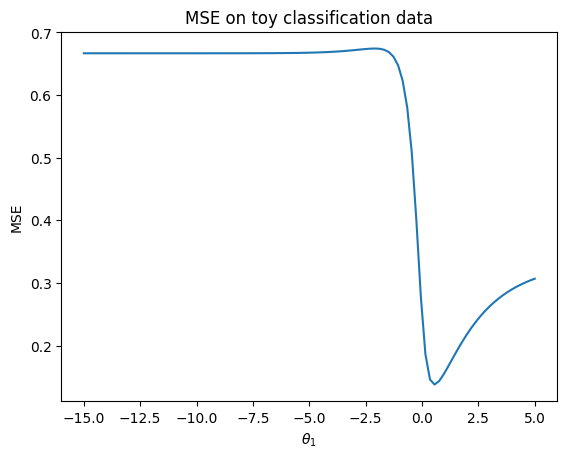

In [11]:
#| code-fold: true
def sigmoid(z):
    return 1/(1+np.e**(-z))
    
def mse_on_toy_data(theta):
    p_hat = sigmoid(toy_df['x'] * theta)
    return np.mean((toy_df['y'] - p_hat)**2)

thetas = np.linspace(-15, 5, 100)
plt.plot(thetas, [mse_on_toy_data(theta) for theta in thetas])
plt.title("MSE on toy classification data")
plt.xlabel(r'$\theta_1$')
plt.ylabel('MSE');

This looks nothing like the parabola we found when plotting the MSE of a linear regression model! In particular, we can identify two flaws with using the MSE for logistic regression:

1. The MSE loss surface is *non-convex*. There is both a global minimum and a (barely perceptible) local minimum in the loss surface above. This means that there is the risk of gradient descent converging on the local minimum of the loss surface, missing the true optimum parameter $\theta_1$.
2. Squared loss is *bounded* for a classification task. Recall that each true $y$ has a value of either 0 or 1. This means that even if our model makes the worst possible prediction (e.g. predicting $p=0$ for $y=1$), the squared loss for an observation will be no greater than 1: $$(y-p)^2=(1-0)^2=1$$ The MSE does not strongly penalize poor predictions.

### Motivating Cross-Entropy Loss
Suffice to say, we don't want to use the MSE when working with logistic regression. Instead, we'll consider what kind of behavior we would *like* to see in a loss function.

Let $y$ be the binary label ${0, 1}$, and $p$ be the model's predicted probability of the label being 1. 

* When the true $y$ is 1, we should incur *low* loss when the model predicts large $p$
* When the true $y$ is 0, we should incur *high* loss when the model predicts large $p$

In other words, our loss function should behave differently depending on the value of the true class, $y$. 

The **cross-entropy loss** incorporates this changing behavior. We will use it throughout our work on logistic regression. Below, we write out the cross-entropy loss for a *single* datapoint (no averages just yet).

$$\text{Cross-Entropy Loss} = \begin{cases}
  -\log{(p)}  & \text{if } y=1 \\
  -\log{(1-p)} & \text{if } y=0
\end{cases}$$

Why does this (seemingly convoluted) loss function "work"? Let's break it down.

:::: {.columns}

::: {.column width="35%"}
When $y=1$
<center><img src="images/y=1.png" alt='cross-entropy loss when Y=1' width='300'></center>

* As $p \rightarrow 0$, loss approches $\infty$
* As $p \rightarrow 1$, loss approaches 0
  
:::

::: {.column width="20%"}
:::

::: {.column width="35%"}
When $y=0$
<center><img src="images/y=0.png" alt='cross-entropy loss when Y=0' width='300'></center>

* As $p \rightarrow 0$, loss approches 0
* As $p \rightarrow 1$, loss approaches $\infty$
  
:::

::::

All good – we are seeing the behavior we want for our logistic regression model.

The piecewise function we outlined above is difficult to optimize: we don't want to constantly "check" which form of the loss function we should be using at each step of choosing the optimal model parameters. We can re-express cross-entropy loss in a more convenient way:

$$\text{Cross-Entropy Loss} = -\left(y\log{(p)}-(1-y)\log{(1-p)}\right)$$

By setting $y$ to 0 or 1, we see that this new form of cross-entropy loss gives us the same behavior as the original formulation.

:::: {.columns}

::: {.column width="35%"}
When $y=1$:

\begin{align}
\text{CE} &= -\left((1)\log{(p)}-(1-1)\log{(1-p)}\right)\\
&= -\log{(p)}
\end{align}
:::

::: {.column width="20%"}
:::

::: {.column width="35%"}
When $y=0$:

\begin{align}
\text{CE} &= -\left((0)\log{(p)}-(1-0)\log{(1-p)}\right)\\
&= -\log{(1-p)}
\end{align}
:::

::::

The empirical risk of the logistic regression model is then the mean cross-entropy loss across all datapoints in the dataset. When fitting the model, we want to determine the model parameter $\theta$ that leads to the lowest mean cross-entropy loss possible.

$$R(\theta) = - \frac{1}{n} \sum_{i=1}^n \left(y_i\log{(p_i)}-(1-y_i)\log{(1-p_i)}\right)$$
$$R(\theta) = - \frac{1}{n} \sum_{i=1}^n \left(y_i\log{(\sigma(X_i^{\top}\theta)}-(1-y_i)\log{(1-\sigma(X_i^{\top}\theta)}\right)$$

The optimization problem is therefore to find the estimate $\hat{\theta}$ that minimizes $R(\theta)$:

\begin{align}
\hat{\theta} = \underset{\theta}{\arg\min} = - \frac{1}{n} \sum_{i=1}^n \left(y_i\log{(\sigma(X_i^{\top}\theta)}-(1-y_i)\log{(1-\sigma(X_i^{\top}\theta)}\right)
\end{align}

Plotting the cross-entropy loss surface for our `toy` dataset gives us a more encouraging result – our loss function is now convex. This means we can optimize it using gradient descent. Computing the gradient of the logistic model is fairly challenging, so we'll let `sklearn` take care of this for us. You won't need to compute the gradient of the logistic model in Data 100.

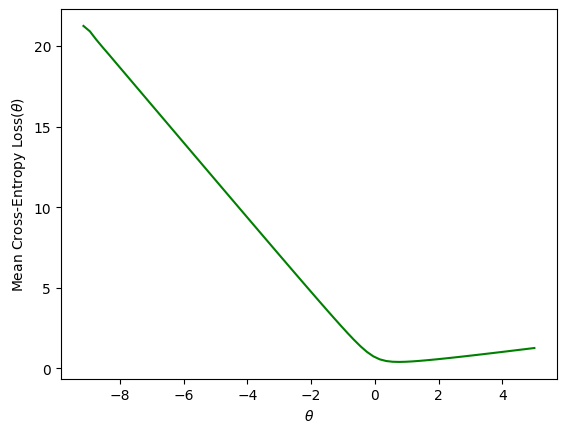

In [12]:
#| code-fold: true
def cross_entropy(y, p_hat):
    return - y * np.log(p_hat) - (1 - y) * np.log(1 - p_hat)

def mean_cross_entropy_on_toy_data(theta):
    p_hat = sigmoid(toy_df['x'] * theta)
    return np.mean(cross_entropy(toy_df['y'], p_hat))

plt.plot(thetas, [mean_cross_entropy_on_toy_data(theta) for theta in thetas], color = 'green')
plt.ylabel(r'Mean Cross-Entropy Loss($\theta$)')
plt.xlabel(r'$\theta$');

## (Bonus) Maximum Likelihood Estimation

It may have seemed like we pulled cross-entropy loss out of thin air. How did we know that taking the negative logarithms of our probabilities would work so well? It turns out that cross-entropy loss is justified by probability theory.

The following section is out of scope, but is certainly an interesting read!

### Building Intuition: The Coin Flip
To build some intuition for logistic regression, let’s look at an introductory example to classification: the coin flip. Suppose we observe some outcomes of a coin flip (1 = Heads, 0 = Tails).

In [ ]:
flips = [0, 0, 1, 1, 1, 1, 0, 0, 0, 0]
flips

A reasonable model is to assume all flips are IID (independent and identically distributed). In other words, each flip has the same probability of returning a 1 (or heads). Let's define a parameter $\theta$, the probability that the next flip is a heads. We will use this parameter to inform our decision for $\hat y$ (predicting either 0 or 1) of the next flip. If $\theta \ge 0.5, \hat y = 1, \text{else } \hat y = 0$.

You may be inclined to say $0.5$ is the best choice for $\theta$. However, notice that we made no assumption about the coin itself. The coin may be biased, so we should make our decision based only on the data. We know that exactly $\frac{4}{10}$ of the flips were heads, so we might guess $\hat \theta = 0.4$. In the next section, we will mathematically prove why this is the best possible estimate.

### Likelihood of Data

Let's call the result of the coin flip a random variable $Y$. This is a Bernoulli random variable with two outcomes. $Y$ has the following distribution: 

$$P(Y = y) = \begin{cases}
        p, \text{if }  y=1\\
        1 - p, \text{if }  y=0
    \end{cases} $$

$p$ is unknown to us. But we can find the $[$ that makes the data we observed the most *likely*.

The probability of observing 4 heads and 6 tails follows the binomial distribution.

$$\binom{10}{4} (p)^4 (1-p)^6$$ 

We define the **likelihood** of obtaining our observed data as a quantity *proportional* to the probability above. To find it, simply multiply the probabilities of obtaining each coin flip.

$$(p)^{4} (1-p)^6$$ 

The technique known as **maximum likelihood estimation** finds the $p$ that maximizes the above likelihood. You can find this maximum by taking the derivative of the likelihood, but we'll provide a more intuitive graphical solution.

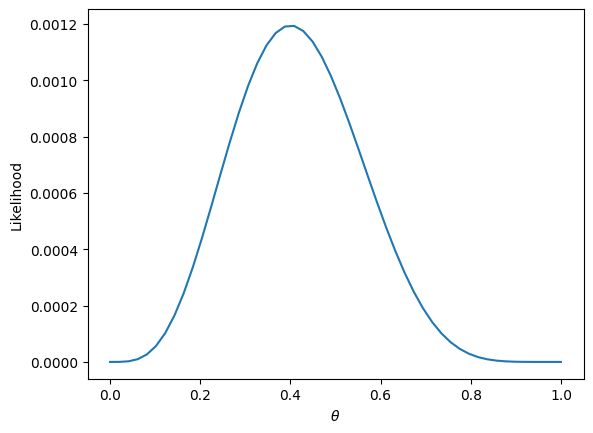

In [13]:
thetas = np.linspace(0, 1)
plt.plot(thetas, (thetas**4)*(1-thetas)**6)
plt.xlabel(r"$\theta$")
plt.ylabel("Likelihood");

More generally, the likelihood for some Bernoulli($p$) random variable $Y$  is:

$$P(Y = y) = \begin{cases}
        1, \text{with probability }  p\\
        0, \text{with probability }  1 - p
    \end{cases} $$
    
Equivalently, this can be written in a compact way:

$$P(Y=y) = p^y(1-p)^{1-y}$$

- When $y = 1$, this reads $P(Y=y) = p$
- When $y = 0$, this reads $P(Y=y) = (1-p)$

In our example, a Bernoulli random variable is analogous to a single data point (e.g., one instance of a basketball team winning or losing a game). All together, our `games` data consists of many IID Bernoulli($p$) random variables. To find the likelihood of independent events in succession, simply multiply their likelihoods.

$$\prod_{i=1}^{n} p^{y_i} (1-p)^{1-y_i}$$

As with the coin example, we want to find the parameter $p$ that maximizes this likelihood. Earlier, we gave an intuitive graphical solution, but let's take the derivative of the likelihood to find this maximum.

At a first glance, this derivative will be complicated! We will have to use the product rule, followed by the chain rule. Instead, we can make an observation that simplifies the problem. 

Finding the $p$ that maximizes $$\prod_{i=1}^{n} p^{y_i} (1-p)^{1-y_i}$$ is equivalent to the $p$ that maximizes $$\text{log}(\prod_{i=1}^{n} p^{y_i} (1-p)^{1-y_i})$$

This is because $\text{log}$ is a strictly *increasing* function. It won't change the maximum or minimum of the function it was applied to. From $\text{log}$ properties, $\text{log}(a*b)$ = $\text{log}(a) + \text{log}(b)$. We can apply this to our equation above to get:

$$\underset{p}{\text{argmax}} \sum_{i=1}^{n} \text{log}(p^{y_i} (1-p)^{1-y_i})$$

$$= \underset{p}{\text{argmax}} \sum_{i=1}^{n} (\text{log}(p^{y_i}) + \text{log}((1-p)^{1-y_i}))$$

$$= \underset{p}{\text{argmax}} \sum_{i=1}^{n} (y_i\text{log}(p) + (1-y_i)\text{log}(1-p))$$

We can add a constant factor of $\frac{1}{n}$ out front. It won't affect the $p$ that maximizes our likelihood.

$$=\underset{p}{\text{argmax}}  \frac{1}{n} \sum_{i=1}^{n} y_i\text{log}(p) + (1-y_i)\text{log}(1-p)$$

One last "trick" we can do is change this to a minimization problem by negating the result. This works because we are dealing with a *concave* function, which can be made *convex*.

$$= \underset{p}{\text{argmin}} -\frac{1}{n} \sum_{i=1}^{n} y_i\text{log}(p) + (1-y_i)\text{log}(1-p)$$

Now let's say that we have data that are independent with different probability $p_i$. Then, we would want to find the $p_1, p_2, \dots, p_n$ that maximize $$\prod_{i=1}^{n} p_i^{y_i} (1-p_i)^{1-y_i}$$

Setting up and simplifying the optimization problems as we did above, we ultimately want to find:

$$= \underset{p}{\text{argmin}} -\frac{1}{n} \sum_{i=1}^{n} y_i\text{log}(p_i) + (1-y_i)\text{log}(1-p_i)$$

For logistic regression, $p_i = \sigma(x^{\top}\theta)$. Plugging that in, we get:  

$$= \underset{p}{\text{argmin}} -\frac{1}{n} \sum_{i=1}^{n} y_i\text{log}(\sigma(x^{\top}\theta)) + (1-y_i)\text{log}(1-\sigma(x^{\top}\theta))$$

This is exactly our average cross-entropy loss minimization problem from before! 

Why did we do all this complicated math? We have shown that *minimizing* cross-entropy loss is equivalent to *maximizing* the likelihood of the training data.

- By minimizing cross-entropy loss, we are choosing the model parameters that are "most likely" for the data we observed.

Note that this is under the assumption that all data is drawn independently from the same logistic regression model with parameter $\theta$. In fact, many of the model + loss combinations we've seen can be motivated using MLE (e.g., OLS, Ridge Regression, etc.). In probability and ML classes, you'll get the chance to explore MLE further.  
